In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer() 
from spacy.lang.en.stop_words import STOP_WORDS
# plt.xkcd()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read the train and test tsv files (seperator is tab that's why tsv)
train = pd.read_csv("../input/mercari-dataset/train.tsv",sep = '\t') 
print("Number of rows {} and columns {} ".format(train.shape[0],train.shape[1]))
train.sample(5)

Number of rows 1482535 and columns 8 


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
582597,582597,Herbalife formula 1 protein drink bundle,1,Other/Daily & Travel items/Sports Nutrition,NaN,110.0,1,Pumpkin spice formula 1 healthy meal Protein d...
146818,146818,LULAROE OS SOLID BLACK NWT,1,Women/Jeans/Leggings,NaN,21.0,0,OS solid black nwt*
358843,358843,La vie est belle + Acqua di Gioia,1,Beauty/Fragrance/Women,Sephora,11.0,1,(4) Lancôme La Vie Est Belle (2) Acqua di Gioi...
17870,17870,10 jigsaw puzzles/ 1box,3,Kids/Toys/Puzzles,NaN,9.0,0,Assortment of 10 puzzles made in America great...
443286,443286,Miniature quartz brass mantle clock,3,Home/Home Décor/Clocks,NaN,5.0,1,Miniature quartz brass mantle clock . Needs a ...


In [3]:
test = pd.read_csv("../input/mercari-dataset/test.tsv",sep = "\t")
print("Number of rows {} and columns {} ".format(test.shape[0],test.shape[1]))
test.sample(5)

Number of rows 693359 and columns 7 


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
167422,167422,Calvin Klein Wallet,4,Women/Women's Accessories/Wallets,Calvin Klein,0,In good condition. Does have signs of wear.
301639,301639,Napoleon Sheer Genius Look 3 Foundation,3,Beauty/Makeup/Face,NaN,1,I am selling a Napoleon Perdis foundation shee...
333932,333932,Boys Northface Jacket Sz L Reversible,4,Kids/Boys (4+)/Coats & Jackets,The North Face,0,**Part of 10% sale. Take advantage before it e...
472664,472664,Clean Cotton T Shirt Perfume,3,NaN,CLEAN,0,Used maybe 4-5 times Size is 2.14 fl oz
215375,215375,Justice volleyball shirt with hood,2,Kids/Girls (4+)/Tops & T-Shirts,Justice,0,Size 12 Justice active volleyball shirt worn a...


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


1. So from above train and test information we can conclude that there are null values in brand name and category name for both files.

2. We will counter this problem by filling in the missing or NaN values.But, first let's explore more features.

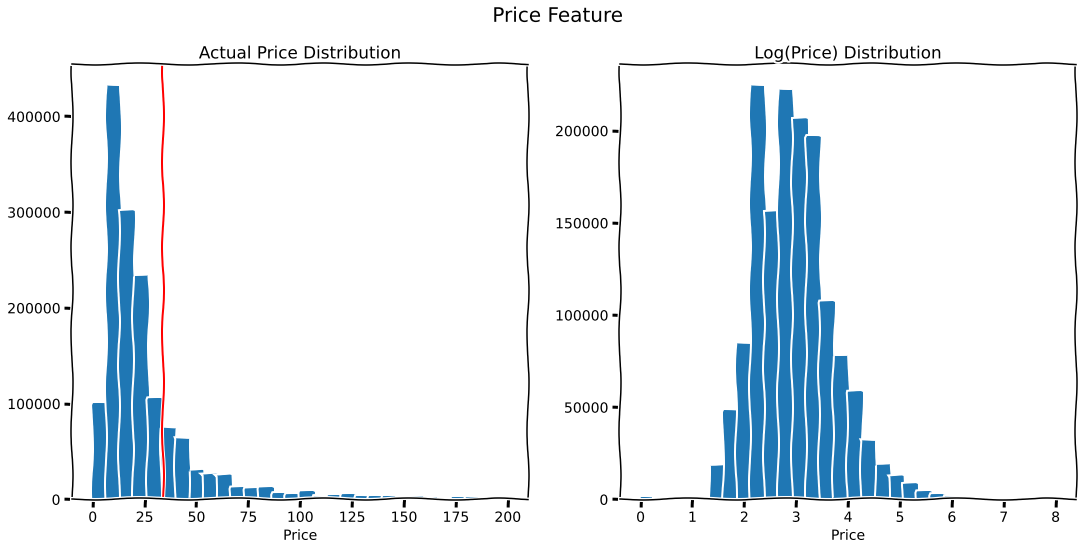

In [6]:
# let's first explore our target variable 
# let's see target variable (price) distribution
plt.xkcd()
fig,(ax1,ax2) = plt.subplots(nrows = 1,ncols=2,figsize = (18,8))
ax1.hist(train.price,bins = 30,range = [0,200])
ax2.hist(np.log(train.price + 1),bins = 30,range = [0,8])
ax1.set_title("Actual Price Distribution")
ax1.axvline(x = np.percentile(train.price,q = 80),color = 'red',label = "80 percent of population lies on left")
ax1.set_xlabel("Price")
ax2.set_title("Log(Price) Distribution")
ax2.set_xlabel("Price")
#plt.legend()
plt.suptitle("Price Feature",fontsize = 20)
plt.show()

1. As you can see from above plot that price feature is having right skewed distribution or you might say it's having power law distribution.

2. It's just an intuition after seeing the plot that variable x (price) can be log-normal distribution i.e log of variable can be normally distributed.

3. After plotting **log(price)** we got normal distribution.

4. Red Line above is giving out the info that 80% of population lies on the left of that line.

In [7]:
# from above analysis it will be better if we add log(Price) as different features, so that forthcoming analysis will be comfortable.
train['log(price)'] = np.log(train['price']+1)
# added new features 
# this is called feature engineering where from the given features you come up with intuitive and useful features.

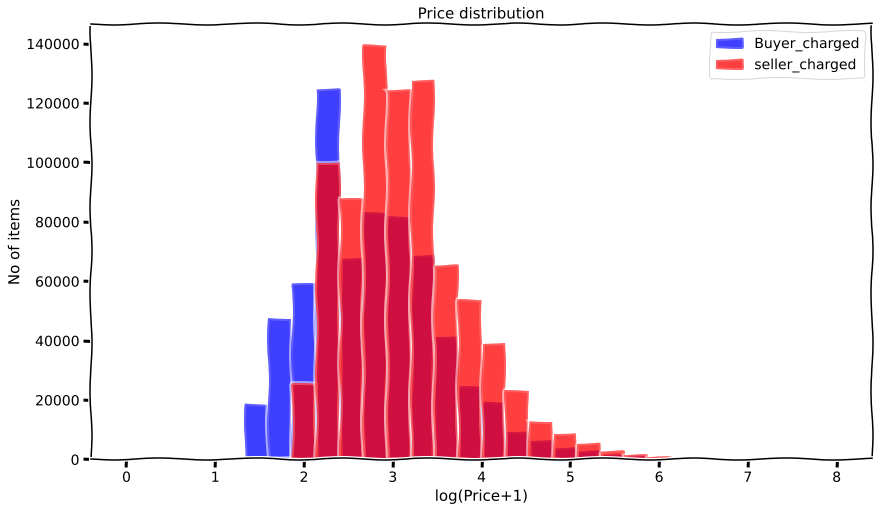

In [8]:
# shipping feature in data seems to be reasonable to explore.
# let's see distribution of shipping data with log(price)

fig, ax = plt.subplots(figsize=(14,8))
ax.hist(train[train.shipping==1]['log(price)'],bins=30,range=[0,8],label="Buyer_charged",color='b',alpha=0.5)
ax.hist(train[train.shipping==0]['log(price)'],bins=30,range=[0,8],label="seller_charged",color='r',alpha=0.5)
plt.title('Price distribution', fontsize=15)
ax.set_xlabel('log(Price+1)',fontsize=15)
ax.set_ylabel('No of items',fontsize=15)
plt.legend(loc='upper right')

plt.show()

1. From above we can't say seller pay the shipping charged if the amount is high because the distribution of both buyer and seller charged is highly overlapping. Hence, we can't come to the conclusion straightaway.

2. The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [9]:
# let's fill in missing data for further analysis with brand name and category name
def fill_missing_data(data):
    data.category_name.fillna(value = "others", inplace = True)
    data.brand_name.fillna(value = "not known", inplace = True)
    data.item_description.fillna(value = "no description", inplace = True)
    return(data)
train = fill_missing_data(train)
#test  = fill_missing_data(test)

In [10]:
# let's also split category_name into 3 parts main_category, sub_category_1 and sub_category_2


# Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle 
# the missing information in the brand_name column will impact the model's prediction.

def split_cat(text):
    try:
        text1, text2, text3 = text.split('/')
        return text1, text2, text3
    except: 
        return ("No Label", "No Label", "No Label")
train['main_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
#test['main_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))


In [11]:
train['summary'] = train['name'] + train['item_description']
#test['summary'] = test['name'] + test['item_description']
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log(price),main_cat,subcat_1,subcat_2,summary
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,not known,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,MLB Cincinnati Reds T Shirt Size XLNo descript...
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,Razer BlackWidow Chroma KeyboardThis keyboard ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,AVA-VIV BlouseAdorable top with a hint of lace...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,not known,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,Leather Horse StatuesNew with tags. Leather ho...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,not known,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,24K GOLD plated roseComplete with certificate ...


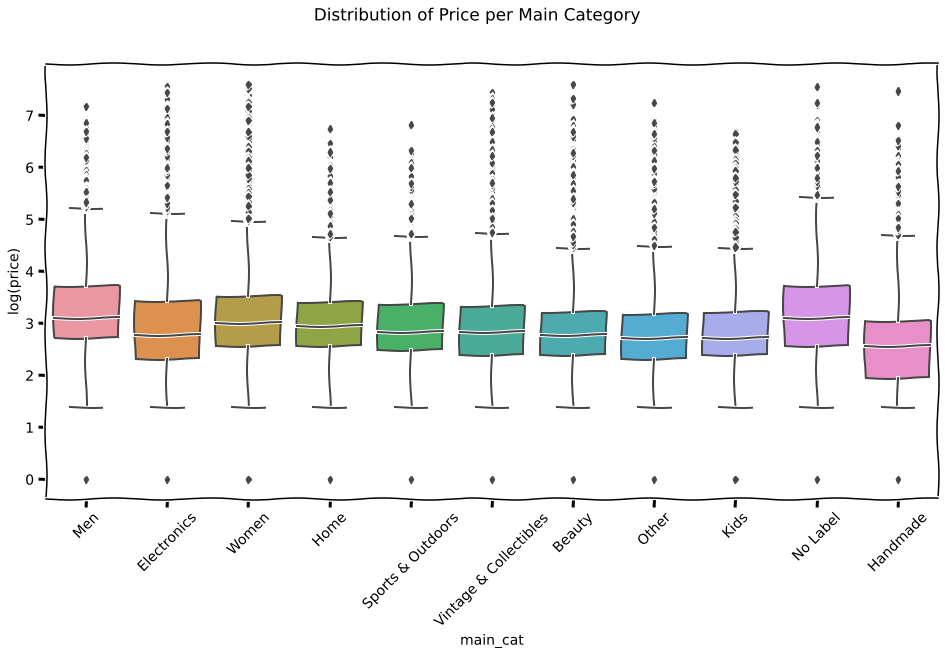

In [12]:
plt.figure(figsize = (16,8))
plt.suptitle("Distribution of Price per Main Category")
sns.boxplot(y = 'log(price)', x = 'main_cat',data = train)
plt.xticks(rotation = 45)
plt.show()


1. Each main category has so much overlapping in prize distribution that no pair of categories price can be distinguished. 

2. Price of each main category is almost completely overlapping.

3. Median of log(Pirce) of Men main category is higher then all present in main category (if we don't count No Label imputaion value. )


In [13]:
import plotly
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Sub Category 1',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=go.Figure(data = trace1,layout=layout)
fig.show()

In [14]:
import plotly
x = train['subcat_2'].value_counts().index.values.astype('str')[:15]
y = train['subcat_2'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Sub Category 2',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=go.Figure(data = trace1,layout=layout)
fig.show()

In [15]:
import re
# here STOP_WORDS is spacy stopwords list
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        #regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        #txt = regex.sub(" ", text)
        txt = re.sub('[^a-zA-Z]+',' ',text)
        words = [lemmatizer.lemmatize(w) for w in txt.split(" ") \
                 if not w in STOP_WORDS and len(w)>3]
        return(len(words))
    except: 
        return 0

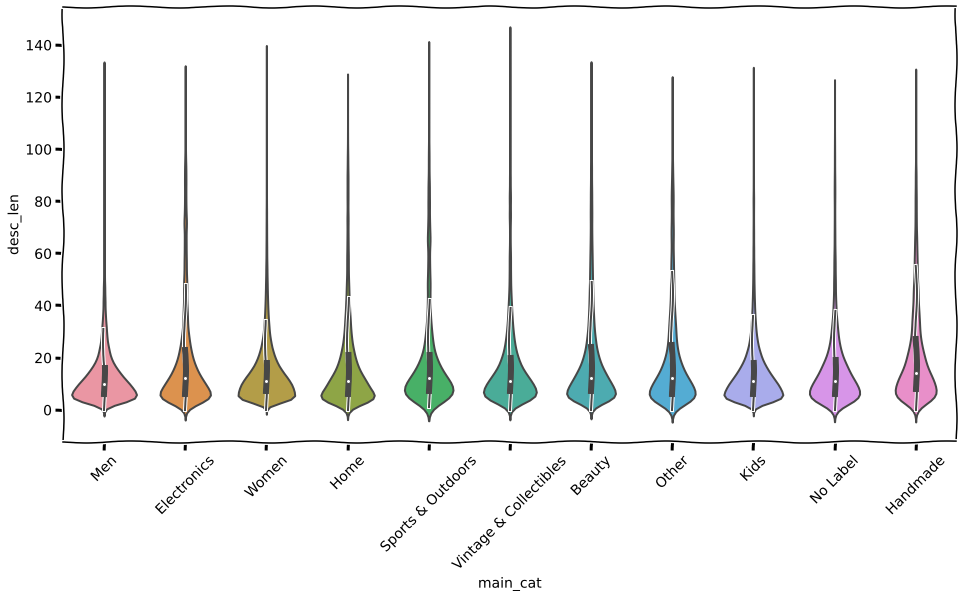

In [16]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['summary'].apply(lambda x: wordCount(x))
plt.figure(figsize = (16,8))
sns.violinplot(x = 'main_cat',y = 'desc_len',data = train)
plt.xticks(rotation = 45)
plt.show()

1. Description Length distribution for each main category is having almost same shape which is right skewed. 

2. And even each category is perfectly aligned to each other, which means just taking desc_len as feature we can't not predict price precisely. They are so much overlapping.

3. You might be thinking why I am making such absurd conclusion even though we are comparing desc_len with main_category. Well, you are right and the reason is given below....

4. If A is correlated with B and B is correlated with C it does not always True that A and C are also correlated.

5. For more info go to https://stats.stackexchange.com/questions/5747/if-a-and-b-are-correlated-with-c-why-are-a-and-b-not-necessarily-correlated

6. But we will explore that is description has any effect on price. Does having long description means it'll have more price on tag?

1. It will be more challenging to parse through this particular item since it's unstructured data. Does it mean a more detailed and lengthy description will result in a higher bidding price?

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


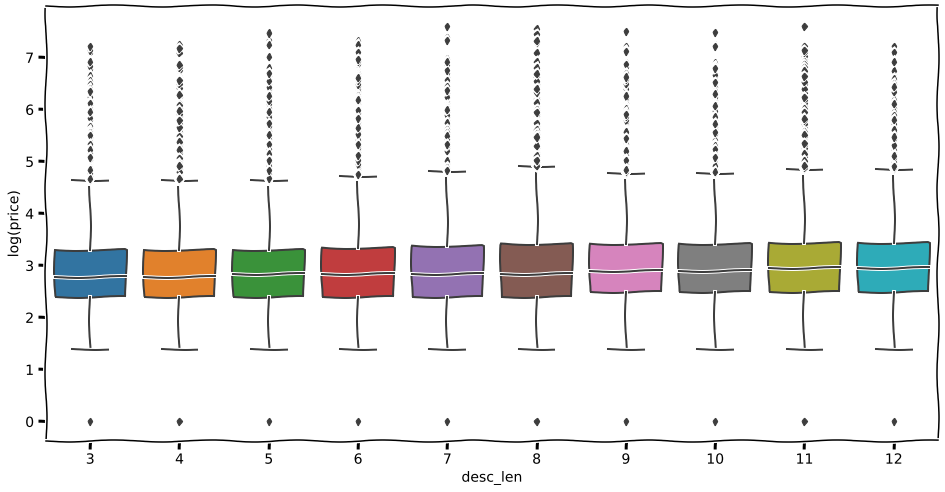

In [17]:
# let's see for top 10 description length the prize distribution.

temp = pd.DataFrame()
for i in tqdm(train['desc_len'].value_counts().index.values[:10]):
    temp = pd.concat([temp,train[train['desc_len']==i]],axis=0)

plt.figure(figsize = (16,8))
sns.boxplot(x = 'desc_len',y = 'log(price)',data = temp)
plt.show()

1. Boxplot of top 10 desc_len have almost the same mean,25th percentile and 75th percentile value.

2. Description Length feature alone can't distinguish the price.

### Loading Twitter Glove Vectors

In [18]:
%%time
embeddings_index = {}
f = open('../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.
CPU times: user 1min 4s, sys: 2.01 s, total: 1min 6s
Wall time: 1min 5s


### Text Preprocessing, Stemming and Removing Stopwords

### Most of the time, the first steps of an NLP project is to "tokenize" your documents, which main purpose is to normalize our texts. The three fundamental stages will usually include:

1. break the descriptions into sentences and then break the sentences into tokens
2. remove punctuation and stop words
3. lowercase the tokens

In [19]:
import re
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def text_preprocess(df):
    pre_list = []
    for sentance in tqdm(df['summary'].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(lemmatizer.lemmatize(e) for e in sent.split() if e.lower() not in stopwords)
        pre_list.append(sent.lower().strip())
    return(pre_list)

In [20]:
train_preprocess = text_preprocess(train)
#test_preprocess = text_preprocess(test)
train['summary'] = train_preprocess
#test['summary'] = test_preprocess

100%|██████████| 1482535/1482535 [07:21<00:00, 3358.68it/s]


### Average Word2Vec

In [23]:
vocab = embeddings_index.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * embeddings_index[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, embeddings_index[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec


In [21]:
def calc_avgw2v(train_preprocess,test_preprocess):
    doc_id = 0
    avg_w2v = []
    # for every description we build a avg vector representation
    for i in tqdm(train_preprocess):
        avg_w2v.append(build_avg_vec(i, 100, doc_id,'avg'))
        doc_id += 1
    # w2v_desc = np.array(# number of doc in courpus * 100), each row corresponds to a doc 
    avg_w2v_train = np.array(avg_w2v)

    avg_w2v = []
    # for every title we build a avg vector representation
    for i in tqdm(test_preprocess):
        avg_w2v.append(build_avg_vec(i, 100, doc_id,'avg'))
        doc_id += 1
    # w2v_title = np.array(# number of doc in courpus * 100), each row corresponds to a doc 
    avg_w2v_test = np.array(avg_w2v)
    return(avg_w2v_train,avg_w2v_test)

In [26]:
avg_w2v_train,_ = calc_avgw2v(train['summary'].values,[])

# splitting the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(avg_w2v_train,train['log(price)'].values, test_size = 0.2,random_state = 42)

100%|██████████| 1482535/1482535 [01:13<00:00, 20280.43it/s]
0it [00:00, ?it/s]


### Let's Clear Doubt

1. If you know about data leakage problem you brain would have definitely striked that "what hell I am doing". How can I split the train data into X_train and X_test after doing featurization.

2. You are right, but you are wrong!!! **Confused Again...**

3. Well you are right in general case but, here for featurization I am using avg_w2v which doesn't need whole training data i.e I am not exposing my whole training data for featurization.

4. If I would have been using tfidf_w2v or idf_w2v then that could be the data leakage. Because tfidf,idf is calculated using all training data.

5. Hope I have clear your doubt...

### First Model - DNN with FineTuning

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Embedding
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

In [29]:
model = Sequential()
model.add(Dense(300,activation=LeakyReLU(),kernel_initializer='glorot_normal',input_shape = (100,)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(300,activation=LeakyReLU(),kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(200,activation=LeakyReLU(),kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(200,activation=LeakyReLU(),kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(100,activation=LeakyReLU(),kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(50,activation=LeakyReLU(),kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               30300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               6

In [30]:
from tensorflow.keras.optimizers import Adam,Nadam

# tf.keras.losses.MeanSquaredLogarithmicError(
#     reduction="auto", name="mean_squared_logarithmic_error"
# )
# mae = tf.keras.losses.MeanAbsoluteError(name = "mean_absolute_error")

reduce_lr = ReduceLROnPlateau(monitor= "mse", factor=0.2,
                              patience=2, min_lr=0.00001)

tnsr_brd = TensorBoard(log_dir='logs')


ckpt = ModelCheckpoint('cnn_model.h5',
                            verbose=1, save_weights_only=True,save_best_only = True)

callbacks = [reduce_lr, tnsr_brd, ckpt ]

adam = Adam(learning_rate = 2e-3)
nadam = Nadam(learning_rate = 1e-4)
model.compile(loss=["mse"], optimizer=nadam)

In [31]:
history = model.fit(X_train,y_train,
                    batch_size=256,
                    epochs=20,
                    verbose=1,
                    validation_data = (X_test,y_test),callbacks = callbacks)

Epoch 1/20
4633/4633 [==============================] - ETA: 0s - loss: 3.0026
Epoch 00001: val_loss improved from inf to 0.48862, saving model to cnn_model.h5
4633/4633 [==============================] - 93s 20ms/step - loss: 3.0026 - val_loss: 0.4886 - lr: 1.0000e-04
Epoch 2/20
4632/4633 [============================>.] - ETA: 0s - loss: 0.6945
Epoch 00002: val_loss improved from 0.48862 to 0.46210, saving model to cnn_model.h5
4633/4633 [==============================] - 89s 19ms/step - loss: 0.6945 - val_loss: 0.4621 - lr: 1.0000e-04
Epoch 3/20
4632/4633 [============================>.] - ETA: 0s - loss: 0.5099
Epoch 00003: val_loss improved from 0.46210 to 0.43725, saving model to cnn_model.h5
4633/4633 [==============================] - 89s 19ms/step - loss: 0.5099 - val_loss: 0.4373 - lr: 1.0000e-04
Epoch 4/20
4633/4633 [==============================] - ETA: 0s - loss: 0.4593
Epoch 00004: val_loss improved from 0.43725 to 0.42065, saving model to cnn_model.h5
4633/4633 [=======

In [44]:
from sklearn.metrics import mean_squared_error

print("root mean squared error is : ",np.sqrt(mean_squared_error(y_test,model.predict(X_test))))

root mean squared error is :  0.6079019093689939


## Model 2 - LightGBM

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train.drop(['price','log(price)'],axis=1),train[['log(price)','price']],test_size = 0.05,random_state = 42)

# Text Encoding --

### Brand Name Feature

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_brnd = CountVectorizer()
vectorizer_brnd.fit(X_train['brand_name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_brandname = vectorizer_brnd.transform(X_train['brand_name'].values)
test_brandname = vectorizer_brnd.transform(X_test['brand_name'].values)


print("After vectorizations")
print(train_brandname.shape)
print(test_brandname.shape)

print(len(vectorizer_brnd.get_feature_names()))

### Name Feature

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_name = CountVectorizer()
vectorizer_name.fit(X_train['name'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_name = vectorizer_name.transform(X_train['name'].values)
test_name = vectorizer_name.transform(X_test['name'].values)


print("After vectorizations")
print(train_brandname.shape)
print(test_brandname.shape)

print(len(vectorizer_name.get_feature_names()))

### Main Category Feature

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_main = CountVectorizer()
vectorizer_main.fit(X_train['main_cat'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_cat = vectorizer_main.transform(X_train['main_cat'].values)
test_cat= vectorizer_main.transform(X_test['main_cat'].values)


print("After vectorizations")
print(train_cat.shape)
print(test_cat.shape)

print(len(vectorizer_main.get_feature_names()))

### Subcategory 1 Feature

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sub_1 = CountVectorizer()
vectorizer_sub_1.fit(X_train['subcat_1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_subcat_1 = vectorizer_sub_1.transform(X_train['subcat_1'].values)
test_subcat_1 = vectorizer_sub_1.transform(X_test['subcat_1'].values)


print("After vectorizations")
print(train_subcat_1.shape)
print(test_subcat_1.shape)

print(len(vectorizer_sub_1.get_feature_names()))

### Subcategory 2 Feature

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sub_2 = CountVectorizer()
vectorizer_sub_2.fit(X_train['subcat_2'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
train_subcat_2 = vectorizer_sub_2.transform(X_train['subcat_2'].values)
test_subcat_2 = vectorizer_sub_2.transform(X_test['subcat_2'].values)


print("After vectorizations")
print(train_subcat_2.shape)
print(test_subcat_2.shape)

print(len(vectorizer_sub_2.get_feature_names()))

### Description Length Feature

In [ ]:
## number of words in description

def tokens(text):
    text = re.sub("[^A-Za-z]+"," ",text)
    return(len(text.split(" ")))

X_train['description_len'] = X_train['item_description'].apply(tokens)
X_test['description_len'] = X_test['item_description'].apply(tokens)

### Standard Scaling of Descripion Length

In [ ]:
from sklearn.preprocessing import Normalizer,StandardScaler,normalize
normalizer = StandardScaler()
normalizer.fit(X_train['description_len'].values.reshape(-1,1))

#X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
train_des_norm = normalizer.transform(X_train['description_len'].values.reshape(-1,1))

test_des_norm = normalizer.transform(X_test['description_len'].values.reshape(-1,1))

print("After normalizations")
print(train_des_norm.shape, y_train.shape)

print(test_des_norm.shape, y_test.shape)

### Sentiment Intensity of Each Item description

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
def sentiment_analyzer(df,preprocess_text):
    temp = [] 
    for sentence in tqdm(preprocess_text):
        for_sentiment = sentence
        ss = sid.polarity_scores(for_sentiment)
        temp.append(ss)
    negative=[]
    neutral=[]
    positive=[]
    compounding=[]
    for i in temp:
        for polarity,score in i.items():
            if(polarity=='neg'):
                negative.append(score)
            if(polarity=='neu'):
                neutral.append(score)
            if(polarity=='pos'):
                positive.append(score)
            if(polarity=='compound'):
                compounding.append(score)
    df['negative']=negative
    df['neutral']=neutral
    df['positive']=positive
    df['compound']=compounding
    return(df)

X_train = sentiment_analyzer(X_train,X_train['item_description'].values)
X_test = sentiment_analyzer(X_test,X_test['item_description'].values)

### Standard Scaling of Sentimental Features

In [28]:
def encoding(feature,tr,ts):
    vectorizer = CountVectorizer()
    vectorizer.fit(tr[feature].values) # fit has to happen only on train data

    # we use the fitted CountVectorizer to convert the text to vector
    train_temp = vectorizer.transform(tr[feature].values)
    test_temp= vectorizer.transform(ts[feature].values)


    print("After vectorizations")
    print(train_temp.shape)
    print(test_temp.shape)

    print(len(vectorizer.get_feature_names()))
    
    
def norm(feature,tr,ts):
    normalizer = StandardScaler()
    normalizer.fit(tr[feature].values.reshape(-1,1))

    #X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
    train_temp = normalizer.transform(tr[feature].values.reshape(-1,1))

    test_temp = normalizer.transform(ts[feature].values.reshape(-1,1))

    print("After normalizations")
    print(train_temp.shape, y_train.shape)

    print(test_temp.shape, y_test.shape)
    return(train_temp,test_temp)

In [ ]:
train_neu,test_neu = norm('neutral',X_train,X_test)
train_pos,test_pos = norm('positive',X_train,X_test)
train_neg,test_neg = norm('negative',X_train,X_test)
train_comp,test_comp = norm('compound',X_train,X_test)

In [ ]:
avg_w2v_train,avg_w2v_test = calc_avgw2v(X_train['summary'].values,X_test['summary'].values)


In [ ]:
from scipy.sparse import csr_matrix
train_dummies = csr_matrix(pd.get_dummies(X_train[['item_condition_id', 'shipping']],
                                          sparse=True).values)

test_dummies = csr_matrix(pd.get_dummies(X_test[['item_condition_id', 'shipping']],
                                          sparse=True).values)


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
vectorizer.fit(X_train['summary'].values)
X_train_itemdes = vectorizer.transform(X_train['summary'].values)
X_test_itemdes = vectorizer.transform(X_test['summary'].values)

### Concatenating Each Feature

In [29]:
from scipy.sparse import hstack
train_data = hstack((X_train_itemdes,avg_w2v_train,train_brandname, train_name,train_dummies,train_cat,train_subcat_1,train_subcat_2,train_des_norm,train_neu,train_neg,train_pos,train_comp))
test_data = hstack((X_test_itemdes,avg_w2v_test,test_brandname,test_name,test_dummies ,test_cat,test_subcat_1,test_subcat_2,test_des_norm,test_neu,test_neg,test_pos,test_comp))
print("Final Data matrix")
print(train_data.shape, y_train['log(price)'].shape)

print(test_data.shape, y_test['log(price)'].shape)
print("="*100)

Final Data matrix
(1408408, 114003) (1408408,)
(74127, 114003) (74127,)


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

In [45]:
lgbm_params ={'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_samples': 50, 'objective': 'regression','boosting_type': 'gbdt','learning_rate': 0.5,
              'max_depth': 8,'n_estimators': 500,'num_leaves': 80,
      }
model = LGBMRegressor(**lgbm_params)
model.fit(train_data, y_train['log(price)'].values,
         verbose=True)

preds2 = model.predict(test_data)

In [32]:
np.sqrt(mean_squared_error(y_test['log(price)'].values, preds2))

0.47191275729394633

In [22]:
sample_sub = pd.read_csv("../input/mercari-dataset-asd/sample_submission.csv")

In [40]:
def predict(dataframe):
    
    dataframe  = fill_missing_data(dataframe)
    dataframe['main_cat'], dataframe['subcat_1'], dataframe['subcat_2'] = zip(*dataframe['category_name'].apply(lambda x: split_cat(x)))
    dataframe['summary'] = dataframe['name'] + dataframe['item_description']
    dataframe['summary'] = text_preprocess(dataframe)
    test_brand = vectorizer_brnd.transform(dataframe['brand_name'].values)
    test_name = vectorizer_name.transform(dataframe['name'].values)
    test_cat= vectorizer_main.transform(dataframe['main_cat'].values)
    test_subcat_1 = vectorizer_sub_1.transform(dataframe['subcat_1'].values)
    test_subcat_2 = vectorizer_sub_2.transform(dataframe['subcat_2'].values)
    dataframe['description_len'] = dataframe['item_description'].apply(tokens)
    test_dummies = csr_matrix(pd.get_dummies(dataframe[['item_condition_id', 'shipping']],
                                          sparse=True).values)
    test_des_norm = normalizer.transform(dataframe['description_len'].values.reshape(-1,1))
    dataframe = sentiment_analyzer(dataframe,dataframe['item_description'].values)
    train_neu,test_neu = norm('neutral',X_train,dataframe)
    train_pos,test_pos = norm('positive',X_train,dataframe)
    train_neg,test_neg = norm('negative',X_train,dataframe)
    train_comp,test_comp = norm('compound',X_train,dataframe)
    avg_w2v = []
    doc_id=0
    for i in tqdm(dataframe['summary'].values):
        avg_w2v.append(build_avg_vec(i, 100, doc_id,'avg'))
        doc_id += 1
    avg_w2v = np.array(avg_w2v)
    X_test_itemdes = vectorizer.transform(dataframe['summary'].values)
    test_data = hstack((X_test_itemdes,avg_w2v,test_brand,test_name,test_dummies,test_cat,test_subcat_1,test_subcat_2,test_des_norm,test_neu,test_neg,test_pos,test_comp))
    return(test_data)

In [41]:
%%time
test_data = predict(test)

  0%|          | 355/693359 [00:00<03:15, 3548.22it/s]

After normalizations
(1408408, 1) (1408408, 2)
(693359, 1) (74127, 2)
After normalizations
(1408408, 1) (1408408, 2)
(693359, 1) (74127, 2)
After normalizations
(1408408, 1) (1408408, 2)
(693359, 1) (74127, 2)
After normalizations
(1408408, 1) (1408408, 2)
(693359, 1) (74127, 2)


100%|██████████| 693359/693359 [00:38<00:00, 18034.50it/s]


CPU times: user 11min 50s, sys: 8.47 s, total: 11min 59s
Wall time: 11min 53s


In [45]:
sample_sub['price'] = np.expm1(model.predict(test_data))
sample_sub.to_csv("submission_lgbm.csv")

# Conclusion

1. I have done some feature engineering like description length, Sentiment Analyzer etc.
2. Price Feature seems to be having log-normal distributon. After taking log(Price) we can see it's forming nearly normal distribution.
3. First Model I have tried using only summary feature which is a combination of two prior faeture i.e item_description and name. I have trained Dense NN with little bit of fine tuning and got RMSLE as 0.60.
4. Second Model I have tried using Bag of Words for each feature and concatenate it with average word2vec feature. I have got RMSLE as 0.47.